In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Retrieve Prepared training data

In [2]:
data_ = pd.read_csv("data_prepared.csv", sep=';')

In [3]:
X = data_.drop(columns="Month 4")
y = data_["Month 4"]

## Train / Test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=42, # keep 42
    test_size=0.2, 
)

# to be refined to obtain train / val  / test ? or cross-val ?


In [5]:
# Get rid off all records with zero values over the 4 months (for the training only)
X_train_NZ = X_train[X_train["Month 1"] + X_train["Month 2"] + X_train["Month 3"] !=0]
y_train_NZ = y_train[X_train["Month 1"] + X_train["Month 2"] + X_train["Month 3"]!=0]

In [6]:
print('Size of each set: ')
print('Total (X, y):', y.count(), '     =   Train_tot:',y_train.count(), '  +  Test_tot:', y_test.count())
print('Total Non Zero Train ', y_train_NZ.count())
print(y_train_NZ.sum())

Size of each set: 
Total (X, y): 1762970      =   Train_tot: 1410376   +  Test_tot: 352594
Total Non Zero Train  522800
36734046.0


## Define metrics


In [7]:
from sklearn.metrics import mean_squared_error

def mse(y_hat, y, squared_ = False):
    """ Compute the Root Mean Squared Error """
    return mean_squared_error(y_hat, y, squared = squared_)

def norm_mse(y_hat, y, squared_ = False):
    """ compute the Root Mean Squared Error normalized by a null prediction"""
    return mean_squared_error(y_hat, y, squared = squared_) / mean_squared_error(np.zeros(y.shape), y, squared = squared_)

def RMSE_hfactory(y_hat, y, squared_ = False):
    R_0 = mean_squared_error(np.zeros(y.shape), y, squared = squared_) 
    rmse_h = (R_0- 0.8 * mse(y_hat, y))/R_0
    return rmse_h

# def score_func(y_hat, y, w, squared_ = False):
#     """ Compute 
#     w = penalize loss for y_hat > y """
#     score = (mean_squared_error(y_hat[y_hat>y], y[y_hat>y], squared=True) * w + mean_squared_error(y_hat[y_hat>y], y[y_hat>y], squared=True))
#     if not squared_:
#         score = np.sqrt(score)
#     score /= mean_squared_error(np.zeros(y.shape), y, squared = squared_)


## Prepare models pipelines

In [8]:
import sklearn
sklearn.set_config(display='diagram')

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), 
    #StandardScaler(),
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant"),
    OneHotEncoder(handle_unknown='ignore'),
)


# cat_col = ['Product Life cycel status', 'Year', 'Quadr', 'Site', 'Strategic Product Family proxy']
cat_col = ['Product Life cycel status', 'Year', 'Quadr', 'Site']


preprocessor = make_column_transformer(
    (numeric_transformer, make_column_selector(dtype_include="float64")),
    (categorical_transformer, cat_col),
    remainder="drop",
)

model_LR =make_pipeline(
    preprocessor,
    LinearRegression(),
)

n_est=500
m_d=7

model_RF = make_pipeline(
    preprocessor,
    RandomForestRegressor(
        n_estimators=n_est,
        max_depth=m_d,
        random_state=42,
        ),
)

model_AB = make_pipeline(
    preprocessor,
    AdaBoostRegressor(
        random_state=42,
        ),
)

model_XGB = make_pipeline(
    preprocessor,
    XGBRegressor(
        random_state=42,
        max_depth=7,
        n_estimators=1000,
        eta=.01,
        # reg_lambda=0,
        # gamma=1,
        # max_cat_threshold=5,
        # subsample=.7,
        # colsample_bytree=.8,
        objective='reg:squarederror',
        ),
)

In [30]:
model_RF

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15a6ed190>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Product Life cycel status',
                                                   'Year', 'Quadr',
                                                   'Site'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=7, n_estimators=500,
                                       random_state=42))])

In [31]:
model_list = [model_RF]

for model_ in model_list:
    #----- Non Zero Training -------
    model_.fit(X_train_NZ, y_train_NZ)

    y_train_hat = model_.predict(X_train)
    y_test_hat = model_.predict(X_test)

    y_train_hat[X_train["Month 1"] + X_train["Month 2"] + X_train["Month 3"]==0] = 0
    y_test_hat[X_test["Month 1"] + X_test["Month 2"] + X_test["Month 3"]==0] = 0
    print(mse(y_train_hat, y_train))
    print(mse(y_test_hat, y_test))
    print(mse(np.zeros(y_test.shape), y_test))
    print(norm_mse(y_test_hat, y_test))
    print(RMSE_hfactory(y_test_hat, y_test))
    print("\n")


364.1736264916278
454.583711527729
649.2042895583725
0.700216740460794
0.4398266076313648




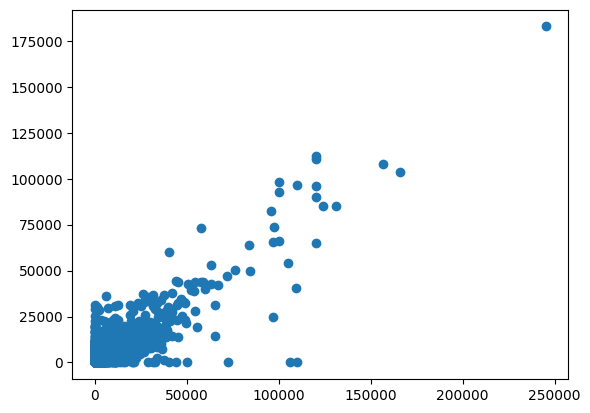

In [15]:
plt.scatter(y_train, y_train_hat)

(-1000.0, 10000.0)

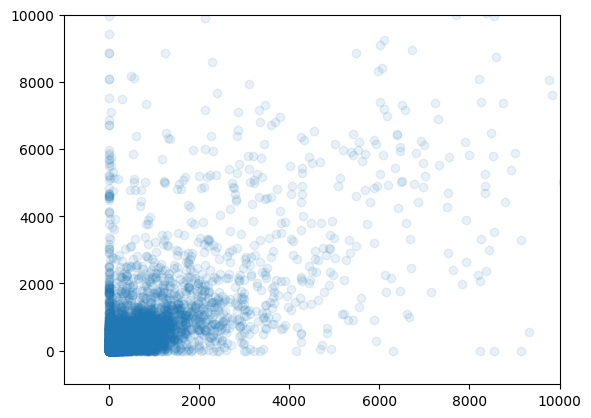

In [17]:
plt.scatter(y_test, y_test_hat, alpha=.1)
plt.xlim(-1000,10000)
plt.ylim(-1000,10000)

## Data Analysis on predicted sales

In [18]:
data_test = pd.concat([X_test, pd.DataFrame(y_test, columns=["Month 4"])], axis=1)
data_test = pd.concat([data_test, pd.DataFrame(y_test_hat, columns=["Predict"], index = y_test.index)], axis=1)

In [19]:
summary=data_test.groupby("Site").sum()
summary.to_csv("data_test.csv", sep=";")

/var/folders/tq/lzmfptz96p1cptz796lf8jr40000gn/T/ipykernel_93066/1468640117.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  summary=data_test.groupby("Site").sum()


## Run the selected model on the test data to be submitted

In [22]:
X_submit = pd.read_csv("X_submit_prepared.csv", sep=";")

In [23]:
# CHOOSE THE SELECTED MODEL HERE--------
y_submit = model_RF.predict(X_submit)
# Crash values for zero volumes
y_submit[X_submit["Month 1"] + X_submit["Month 2"] + X_submit["Month 3"]==0] = 0

In [24]:
# Prepare expected submission format
y_submit_ = pd.concat([X_submit["index"], pd.DataFrame(y_submit, columns=["Month 4"])], axis=1)


In [26]:
# Check submission data
y_submit_

,index,Month 4
0,490548,9685.768456
1,2167957,0.000000
2,1999013,8.215690
3,469221,93.758169
4,1171716,8.215690
...,...,...
440738,849490,8.215690
440739,1199858,0.000000
440740,1007643,0.000000
440741,1647728,8.215690


In [28]:
# Generate csv file for submission 
y_submit_.to_csv("y_test_team21_3.csv", index=False, sep=";")